In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

tf.enable_eager_execution()
tf.set_random_seed(230)
print(tf.__version__)

from matplotlib import pyplot as plt

import sys
sys.path.append('..')

/Documents/venv3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.11.0


In [20]:
from configs.seq_bidirectional_fd_gru import hparams
hparams = hparams()
print(hparams)

[('batch_size', 800), ('datagen', 'prodn'), ('in_seq_len', 120), ('input_channels', 2), ('input_dim', 1), ('lambd', 1e-06), ('learning_rate', 0.001), ('logs_path', '/tmp/tensorflow_logs'), ('lr_decay', 0.99), ('neurons_unit', 32), ('norm_epsilon', 1e-12), ('num_layers', 1), ('out_seq_len', 24), ('output_channels', 2), ('output_dim', 1), ('test_split', 0.1), ('train_split', 0.8), ('val_split', 0.1)]


In [24]:
from data_loader.biogas import *
get_fields = 'AT305 AT303 FT202'
get_fields = 'AT305 AT303'
dataset, dataset_val, dataset_test = load_data(hparams, mode=get_fields)

### Define Model

In [5]:
class OneStepAttention(tf.keras.Model):
    def __init__(self, neurons_unit, in_seq_len, name=''):
        super(OneStepAttention, self).__init__()
        self.rpt = tf.keras.layers.RepeatVector(in_seq_len)
        self.cat = tf.keras.layers.Concatenate(axis=-1)
        self.W1 = tf.keras.layers.Dense(neurons_unit, activation = "tanh", name=name + '_W1')
        self.W2 = tf.keras.layers.Dense(1, activation = "relu", name=name + '_W2')
        self.softmax = tf.keras.layers.Activation('softmax', name='attention_weights')
        
    def call(self, hidden_states, prev_state):
    
        # Repeat previous hidden state and concatenate with hidden states
        s_prev = self.rpt(prev_state)
        a0 = self.cat([hidden_states, s_prev])

        # Propagate and calculate softmax activation
        a1 = self.W1(a0)
        a2 = self.W2(a1)
        a2 = tf.keras.backend.squeeze(a2, -1)
        a3 = self.softmax(a2)
        a3 = tf.keras.backend.expand_dims(a3)

        # Compute context vector
        context = tf.keras.layers.Dot(axes = 1)([a3, hidden_states])
        
        return context

In [6]:
def gru(units, name):
    # Use CuDNNGRU is GPU is available (provides a 3x speedup than GRU)
    if tf.test.is_gpu_available():
        return tf.keras.layers.CuDNNGRU(units, 
                                        return_sequences=True, 
                                        return_state=True, 
                                        recurrent_activation='sigmoid',
                                        recurrent_initializer='glorot_uniform',
                                        name=name)
    else:
        return tf.keras.layers.GRU(units, 
                                   return_sequences=True, 
                                   return_state=True, 
                                   recurrent_activation='sigmoid', 
                                   recurrent_initializer='glorot_uniform',
                                   name=name)

In [10]:
class BidirectionalEncDec(tf.keras.Model):
    def __init__(self, output_dim, num_layers, neurons_unit, batch_size, in_seq_len):
        super(BidirectionalEncDec, self).__init__()
        self.output_dim   = output_dim
        self.num_layers   = num_layers
        self.neurons_unit = neurons_unit
        self.batch_size   = batch_size
        
        self.encoder = tf.keras.layers.Bidirectional(gru(neurons_unit, 'encoder'))
        self.decoder = gru(neurons_unit, 'decoder')
        self.dec_out = tf.keras.layers.Dense(output_dim, activation='relu', name='decoder_affine')
        self.attention = OneStepAttention(neurons_unit, in_seq_len, 'bi_enc_attn')
    
    def call(self, inp, mask, trace=False):
        """
        Arguments:
            x: Inputs dataset
            out_seq_len: Number of steps to predict
        Returns:
            pred: Model predictions
        """
        if trace: import pdb; pdb.set_trace()
        # Step 1: Run bidirectional encoder
        enc_output, _, _ = self.encoder(inp)
        dec_state = tf.zeros((inp.shape[0], self.neurons_unit))
        out = tf.slice(inp, [0, inp.shape[1]-1, inp.shape[2]-self.output_dim], [-1, 1, self.output_dim])

        # Step 2: Run decoder for t steps        
        for t in range(inp.shape[1]):

            # Calculate attention vector, concatenate with raw input
            """
            TODO: Try concatenating enc_output
            """
            mask_t  = tf.slice(mask,  [0, t, 0], [-1, 1, -1])
            inp_t   = tf.slice(inp,   [0, t, 0], [-1, 1, -1])
            context = self.attention(enc_output, dec_state)
            context = tf.keras.layers.Concatenate(axis=-1)([inp_t, out, context])

            # Pass to decoder
            dec_output, dec_state = self.decoder(context, initial_state = [dec_state])
            dec_state = tf.keras.backend.clip(dec_state, -5, 5)
            out = self.dec_out(dec_output) * mask_t

            if t == 0:
                outputs = out
            else:
                outputs = tf.concat([outputs, out], axis=1)

        return outputs

## Train Model
loss_function: Build out MSE loss function with parameter regularisation

train_model: Runs the minibatch training loop

Epoch 1 Loss 0.2746 Accuracy 0.2732
Time taken for 1 epoch 69.5957 sec

Epoch 2 Loss 0.0534 Accuracy 0.0519
Time taken for 1 epoch 68.3841 sec

Epoch 3 Loss 0.0644 Accuracy 0.0628
Time taken for 1 epoch 68.4204 sec

Epoch 4 Loss 0.0544 Accuracy 0.0528
Time taken for 1 epoch 68.3671 sec

Epoch 5 Loss 0.0381 Accuracy 0.0365
Time taken for 1 epoch 69.1825 sec

Epoch 6 Loss 0.0260 Accuracy 0.0244
Time taken for 1 epoch 68.9061 sec

Epoch 7 Loss 0.0227 Accuracy 0.0212
Time taken for 1 epoch 68.8430 sec

Epoch 8 Loss 0.0191 Accuracy 0.0176
Time taken for 1 epoch 69.2688 sec

Epoch 9 Loss 0.0170 Accuracy 0.0155
Time taken for 1 epoch 72.0084 sec

Epoch 10 Loss 0.0152 Accuracy 0.0138
Time taken for 1 epoch 69.3651 sec

Loss 0.0152 Accuracy 0.0138 Time 692.3418


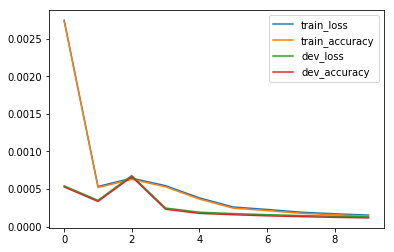

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection multiple                  8256      
_________________________________________________________________
decoder (GRU)                multiple                  10464     
_________________________________________________________________
decoder_affine (Dense)       multiple                  66        
_________________________________________________________________
one_step_attention_3 (OneSte multiple                  3137      
Total params: 21,923
Trainable params: 21,923
Non-trainable params: 0
_________________________________________________________________


In [16]:
import trainers.tf_eager_trainer as trainer

# Run a training batch
tf.set_random_seed(231) # Set seed

# Initialise model and optimiser
model = BidirectionalEncDec(hparams.output_channels, hparams.num_layers, hparams.neurons_unit,
                            hparams.batch_size, hparams.in_seq_len)
optimizer = tf.train.AdamOptimizer(learning_rate = hparams.learning_rate)

# Start training run
loss, accuracy, run_time, stats = trainer.train_model(model, optimizer, dataset, hparams,
                                                      epochs=10, verbose=True, dev_dataset=dataset_val)

# Display results
print('Loss {:.4f} Accuracy {:.4f} Time {:.4f}'.format(loss * 100, accuracy * 100, run_time))

plt.figure()
for name, stat in stats.items():
    if name != 'time':
        plt.plot(stat, label=name)
plt.legend()
plt.show()

model.summary()

In [ ]:
# show all sequences
# Select target sequence to show
TARGET_INDEX = 799

# Create forecast and rescale data
_, (inp, target, mask, x_max) = enumerate(dataset).__next__()
forecast = model(inp, mask)
forecast *= x_max
target   *= x_max
inp = np.reshape(inp, [hparams.batch_size, hparams.in_seq_len, hparams.input_dim, hparams.input_channels])
inp *= np.reshape(x_max, [hparams.batch_size,1,1,-1])

# Plot target sequence
plt.figure(figsize=(16,12))
plt.plot(np.squeeze(forecast[TARGET_INDEX,:,0]), label='forecast')
plt.plot(np.squeeze(target[TARGET_INDEX,:,0]), label='target')
plt.plot(np.mean(inp, axis=2)[TARGET_INDEX,:,0], 'bo', label='5 period average')
for i in range(hparams.input_dim):
    plt.plot(np.array(inp)[TARGET_INDEX,:,i,0], '--', label='%i periods prior' % (5-i))
plt.legend()
plt.yscale('log')
plt.show()

"""plt.figure(figsize=(16,16))
for i in range(0,100):
    ax = plt.subplot(10,10,i+1)
    ax.plot(np.squeeze(pred[i]), label='forecast')
    ax.plot(np.squeeze(target[i]), label='target')
plt.show()"""